In [1]:
import scanpy as sc
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import seaborn as sns
import bbknn

In [2]:
import sys
sys.path.insert(0, "../lib")
import sc_utils

In [4]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["figure.figsize"] = (8, 8)
pd.set_option('display.max_rows', 500)

In [ ]:
ds_full = sc.read_h5ad("../data/02dataset/integrated-manual.h5ad")

In [ ]:
sc.pl.umap(ds_full, color="leiden", size=15, legend_loc="on data")

## Subset only on Epithelial clusters

In [ ]:
epithelial_clusters = ["3", "8", "9", "10"]

In [ ]:
ds = ds_full[ds_full.obs.leiden.isin(epithelial_clusters), :].copy()

In [ ]:
ds.obs["COVID-19"] = ds.obs["COVID-19"].astype("category")

In [ ]:
ds = ds.raw.to_adata()
sc.pp.highly_variable_genes(ds, n_top_genes=3000, batch_key="orig.ident")
ds.raw = ds

sc.pp.scale(ds)
sc.tl.pca(ds, svd_solver="arpack")
sc.pl.pca_variance_ratio(ds)

In [ ]:
bbknn.bbknn(ds, neighbors_within_batch=int(50 / ds.obs.batch.unique().size), n_pcs=15)

In [ ]:
sc.tl.leiden(ds, resolution=0.5)
sc.tl.umap(ds)

In [ ]:
ax = sc.pl.umap(
    ds, 
    color="leiden", 
    size=15, 
    legend_loc="on data", 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
ax = sc.pl.umap(
    ds, 
    color="Sample Name", 
    size=15, 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
ax = sc.pl.umap(
    ds, 
    color="COVID-19", 
    size=15, 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
sc.tl.dendrogram(ds, groupby="leiden")
sc.pl.dendrogram(ds, groupby="leiden")

In [ ]:
sc.tl.rank_genes_groups(ds, "leiden", method="wilcoxon", n_genes=0)
markers = sc_utils.get_markers(ds, "leiden")

## Marker genes for clusters

In [ ]:
markers.groupby("cluster").head(20)

## Violin plot for a collection of epithelial marker genes

In [ ]:
genes = [
    "SCGB3A1", "MUC5B", "SFTPC", "LAMP3", "HOPX", "AGER", "KRT5", "FOXJ1", "S100A2", "KRT17"
]
ax = sc.pl.stacked_violin(
    ds,
    genes,
    groupby="leiden",
    rotation=90,
    figsize=(10, 10),
    show=False
);

## Name clusters

Clusters 1, 2 & 6 are strange

In [ ]:
names = pd.Series([
    "AT2-1",
    "AT2-2",
    "AT2-3",
    "Club cells",
    "Ciliated cells 1",
    "Basal cells",
    "Ciliated cells 2",
    "AT1",
])

In [ ]:
ds.obs["cluster"] = names[ds.obs.leiden.astype(int)].values

In [ ]:
ax = sc.pl.umap(
    ds, 
    color="cluster", 
    size=15, 
    show=False, 
    legend_loc="on data",
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
sc_utils.plot_composition(ds, "cluster", "COVID-19")

Clusters `AT2-2`, `AT2-3` and `Ciliated cells 1` are dominated by cells from COVID-19 patients

In [ ]:
sc_utils.plot_composition(ds, "cluster", "Sample Name")

## Doublets

In [ ]:
dbl_thresholds = {
    "Sample_1": 0.22,
    "Sample_2": 0.3,
    "Sample_3": 0.35,
    "Sample_4": 0.37,
    "Sample_5": 0.4,
    "Sample_6": 0.25,
    "Sample_7": 0.26,
    "Sample_8": 0.41,
    "Sample_9": 0.38,
    "Sample_10": 0.25,
    "Sample_11": 0.4,
    "Sample_12": 0.37,
    "Sample_13": 0.34,
    "Sample_14": 0.38,
    "Sample_15": 0.33,
    "Sample_16": 0.4,
    "Sample_17": 0.38,
    "Sample_18": 0.39,
    "Sample_19": 0.4,
    "Sample_20": 0.4,
    "Sample_21": 0.28,
    "Sample_22": 0.28
}

In [ ]:
doublets = []
for sample, threshold in dbl_thresholds.items():
    batch_num = ds.obs.batch.loc[ds.obs["orig.ident"] == sample].values[0]
    scores = pd.read_csv(f"doublets/{sample}_doublets.csv", index_col=0)
    sample_doublets = "0_" + scores["0"].loc[scores.doublet > threshold].str.replace("\d+$", "") + batch_num
    doublets.append(sample_doublets)
    print(f"{sample} has {sample_doublets.size}")
doublets = pd.concat(doublets)
doublets.shape

In [ ]:
ds.obs["doublet"] = False
ds.obs.doublet[ds.obs_names.isin(doublets)] = True
ds.obs.doublet = ds.obs.doublet.astype("category")
ds.obs.doublet.value_counts()

In [ ]:
ax = sc.pl.umap(
    ds, 
    color="doublet", 
    size=15, 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5,
    cmap="YlOrRd"
)

In [ ]:
sc_utils.plot_composition(ds, "cluster", "doublet")

## Reprocess without doublets

In [ ]:
ds2 = ds.raw.to_adata()

In [ ]:
ds2 = ds2[~ds2.obs.doublet.astype(bool), :]

In [ ]:
sc.pp.highly_variable_genes(ds2, n_top_genes=2000, batch_key="orig.ident")
ds2.raw = ds2

sc.pp.scale(ds2)
sc.tl.pca(ds2, svd_solver="arpack")
sc.pl.pca_variance_ratio(ds2)

In [ ]:
bbknn.bbknn(ds2, neighbors_within_batch=int(50 / ds2.obs.batch.unique().size), n_pcs=10)

In [ ]:
sc.tl.leiden(ds2, resolution=1.2)
sc.tl.umap(ds2)

In [ ]:
ax = sc.pl.umap(
    ds2, 
    color="leiden", 
    size=15, 
    legend_loc="on data", 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
ax = sc.pl.umap(
    ds2, 
    color="Sample Name", 
    size=15, 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
ax = sc.pl.umap(
    ds2, 
    color="COVID-19", 
    size=15, 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
sc.tl.dendrogram(ds2, groupby="leiden")
sc.pl.dendrogram(ds2, groupby="leiden")

In [ ]:
sc.tl.rank_genes_groups(ds2, "leiden", method="wilcoxon", n_genes=0)
markers = sc_utils.get_markers(ds2, "leiden")

In [ ]:
markers.groupby("cluster").head(10)

In [ ]:
markers.loc[markers.cluster.isin(["3", "8", "11"]), :].groupby("cluster").head(40)

Cluster 3 has no specific genes, I'll call them low-quality cells, remove and recluster. Cluster 8 also does not have specific genes, besides XIST

## Without low-quality cells

In [ ]:
ds3 = ds2.raw.to_adata()

In [ ]:
ds3 = ds3[~ds3.obs.leiden.isin(["3", "8"]), :]

In [ ]:
sc.pp.highly_variable_genes(ds3, n_top_genes=2000, batch_key="orig.ident")
ds3.raw = ds3

sc.pp.scale(ds3)
sc.tl.pca(ds3, svd_solver="arpack")
sc.pl.pca_variance_ratio(ds3)

In [ ]:
bbknn.bbknn(ds3, neighbors_within_batch=int(50 / ds3.obs.batch.unique().size), n_pcs=10)

In [ ]:
sc.tl.leiden(ds3, resolution=1.2)
sc.tl.umap(ds3)

In [ ]:
ax = sc.pl.umap(
    ds3, 
    color="leiden", 
    size=15, 
    legend_loc="on data", 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
ax = sc.pl.umap(
    ds3, 
    color="Sample Name", 
    size=15, 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
ax = sc.pl.umap(
    ds3, 
    color="COVID-19", 
    size=15, 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5
)

In [ ]:
sc.tl.rank_genes_groups(ds3, "leiden", method="wilcoxon", n_genes=0)
markers = sc_utils.get_markers(ds3, "leiden")

In [ ]:
markers["pct.diff"] = markers["pct.1"] - markers["pct.2"]
markers.loc[markers["pct.diff"] > 0.6]

In [ ]:
markers.groupby("cluster").head(10)

In [ ]:
sc.tl.dendrogram(ds3, groupby="leiden")
sc.pl.dendrogram(ds3, groupby="leiden")

Merging: 2+14, 4+11, 8+16

In [ ]:
genes = [
    "SCGB3A1", "MUC5B", "SFTPC", "LAMP3", "HOPX", "AGER", "KRT5", 
    "FOXJ1", "S100A2", "KRT17", "CLDN18", "PEG10", "CLIC5", "MMP10"
]
ax = sc.pl.stacked_violin(
    ds3,
    genes,
    groupby="leiden",
    rotation=90,
    figsize=(10, 14),
    show=False
);

In [ ]:
sc.pl.violin(ds3, "pct_counts_mito", "leiden")

In [11]:
names = pd.Series([
    "AT2-1",                 # 0
    "AT2-2",                 # 1
    "AT2-2",      # 2
    "Club",                 # 3
    "Ciliated",                 # 4
    "AT2-1",            # 5
    "Transitional AT2",
    "Basal 1",
    "Ciliated",
    "Basal 2",
    "Ciliated",
    "Ciliated",
    "Basal 3",
    "AT1",
    "AT2-2",
    "Doublets",
    "Ciliated"
])

In [12]:
ds3.obs["cluster"] = names[ds3.obs.leiden.astype(int)].values

In [ ]:
ds3 = ds3[ds3.obs.cluster != "Doublets", :].copy()

In [6]:
sc.tl.rank_genes_groups(ds3, "cluster", method="wilcoxon", n_genes=0)
markers = sc_utils.get_markers(ds3, "cluster")

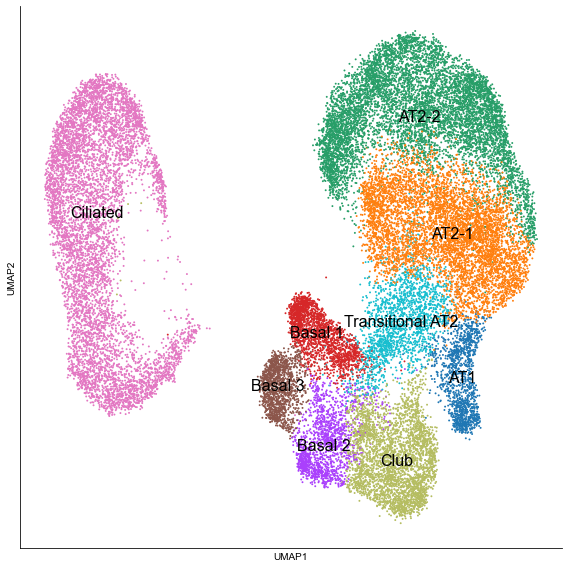

In [16]:
ax = sc.pl.umap(
    ds3, 
    color="cluster", 
    size=15, 
    show=False, 
    legend_loc="on data",
    legend_fontsize=16, 
    legend_fontweight="normal",
#     legend_fontoutline=5
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("plots/01epithelial-umap.pdf")

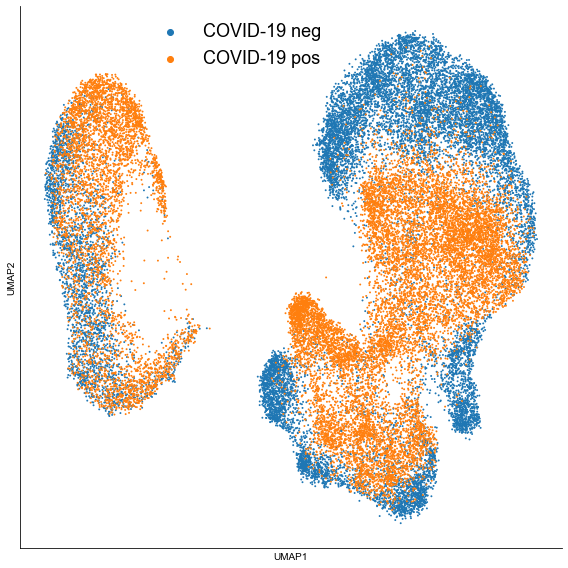

In [17]:
ax = sc.pl.umap(
    ds3, 
    color="COVID-19", 
    size=15, 
    show=False, 
    legend_fontsize=18, 
    legend_fontweight="normal",
#     legend_fontoutline=5
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["COVID-19 neg", "COVID-19 pos"], frameon=False, fontsize=18, 
          loc="upper center", bbox_to_anchor=(0.4, 1))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("plots/04epithelial-covid.pdf")

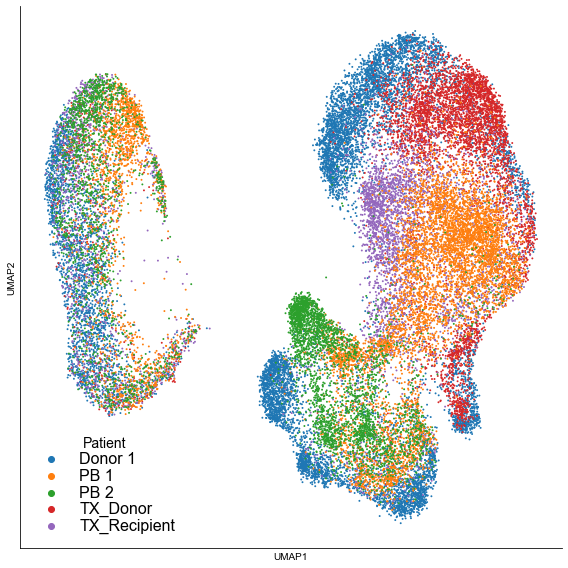

In [8]:
ax = sc.pl.umap(
    ds3, 
    color="Sample Name", 
    size=15, 
    show=False, 
#     legend_loc="on data",
    legend_fontsize=18, 
    legend_fontweight="normal",
#     legend_fontoutline=5
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, frameon=False, title="Patient", title_fontsize=14,
          fontsize=16, loc="lower left", labelspacing=0.1)#, bbox_to_anchor=(0.4, 1))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("plots/04epithelial-patient.pdf")

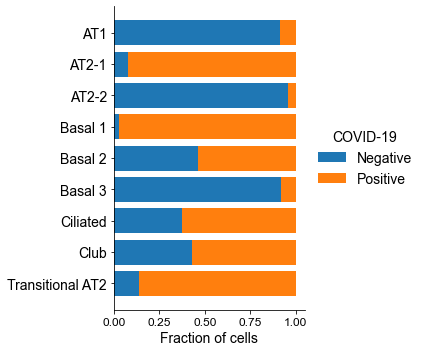

In [10]:
left = np.zeros(len(ds3.obs.cluster.unique()))
fig, ax = plt.subplots(figsize=(6, 5))
totals = ds3.obs.cluster.value_counts().sort_index()
for s in sorted(ds3.obs["COVID-19"].astype(str).unique()):
    cnt = ds3.obs.cluster[ds3.obs["COVID-19"] == s].value_counts().sort_index() / totals
    ax.barh(list(reversed(cnt.index)), list(reversed(cnt.values)), left=left, label=s)
    left += list(reversed(cnt))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Negative", "Positive"], title="COVID-19", 
          loc="center left", bbox_to_anchor=(1, 0.5),
          frameon=False, fontsize=14, title_fontsize=14)
# ax.set_title("Cluster by patient", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=12)#, rotation=45)
ax.tick_params(axis="y", labelsize=14)
# ax.set_xticklabels([
#     "CD4 T cells", "Tregs", "CD8 T cells", 
#     "Proliferating CD4 T cells", "Proliferating CD8 T cells",
#     "MoAM1", "MoAM2", "MoAM3", "TRAM1", "TRAM2"
# ], ha="right")
ax.set_xlabel("Fraction of cells", fontsize=14)
ax.figure.tight_layout()
ax.figure.savefig("plots/05epithelial-covid-clusters.pdf")

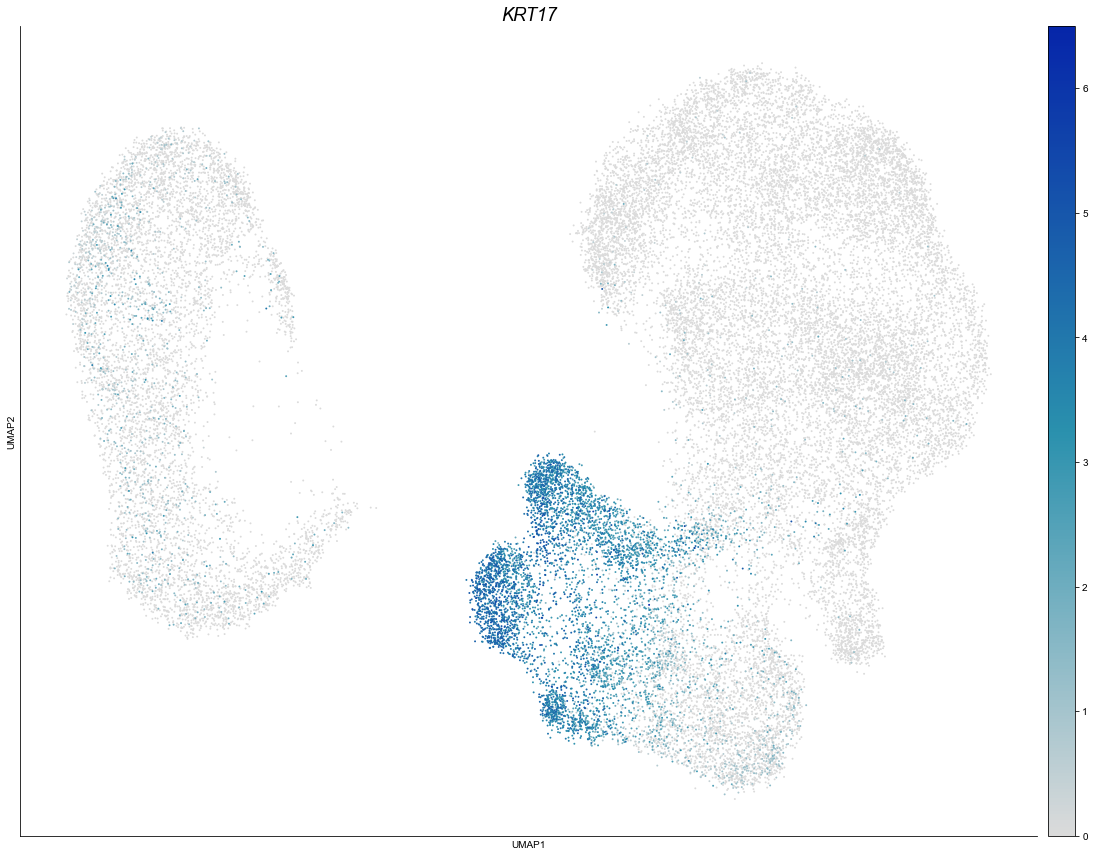

In [19]:
ax = sc.pl.umap(
    ds3, 
    color="KRT17", 
    size=15, 
    show=False, 
    legend_loc="on data",
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5,
    cmap=sc_utils.expr_colormap()
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("KRT17", fontstyle="italic", fontsize=18)
ax.figure.tight_layout()
ax.figure.savefig("plots/02epithelial_krt17.pdf")

## Plot genes mentioned in the paper

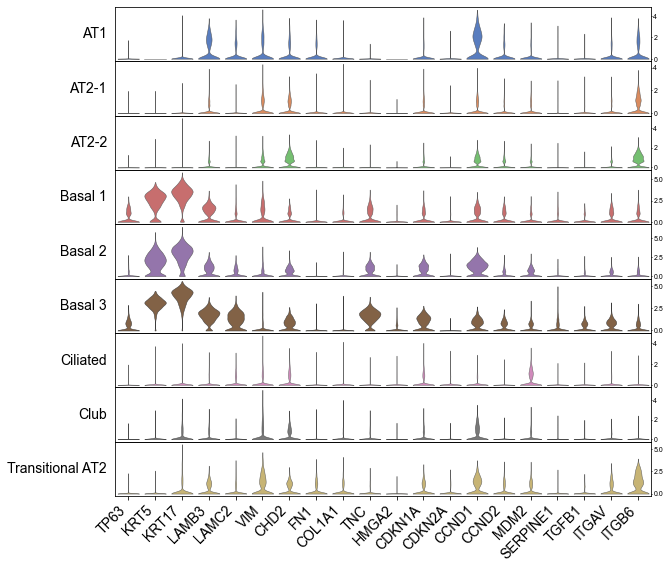

In [22]:
paper_genes = [
    "TP63", "KRT5", "KRT17", "LAMB3", "LAMC2", 
    "VIM", "CHD2", "FN1", "COL1A1", "TNC", 
    "HMGA2", "CDKN1A", "CDKN2A", "CCND1", "CCND2", 
    "MDM2", "SERPINE1", "TGFB1", "ITGAV", "ITGB6"
]

ax = sc.pl.stacked_violin(
    ds3,
    paper_genes,
    groupby="cluster",
    rotation=90,
    figsize=(10, 9),
    show=False,
)
for a in ax:
    a.set_ylabel(a.get_ylabel(), fontsize=14)
    p = a.get_position()
    p.x0 += 0.1
    p.x1 += 0.1
    a.set_position(p)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=14, ha="right");
ax[0].figure.savefig("plots/03epithelial-violins.pdf")

In [24]:
ds3.write_h5ad("../data/02dataset/11epithelial.h5ad")

In [92]:
markers["cluster"] = names[markers.cluster.astype(int)].values

In [7]:
markers.to_csv("../data/02dataset/11epithelial-markers.csv")